#Transfert Leraning Formative

In this notbook, we are experimenting  transfer learning using pre-trained models (VGG16, ResNet50, and InceptionV3) applied to healthcare (enhancing healthcare infrastructure in Chad with AI). The dataset used in this example is from ISIC Skin Lesion Dataset

## Mission and GCGOs (Great Challenges and Great Opportunities)

**Mission**: Using AI to enhance high-tech infrastructure in Chad by improving healthcare and education systems.

**Great Challenges and Great Opportunities (GCGOs):**

**Infrastructure**: Chad faces challenges in developing modern infrastructure for healthcare, which AI can help overcome.

**Healthcare**: Leveraging AI to improve diagnostic accuracy and efficiency in healthcare.

**Education**: Using AI to provide personalized and scalable educational tools.

# Importing necessary libraries


In [ ]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


# Downloading dataset from Kaggle

In [ ]:

!pip install kaggle

In [ ]:
# Assuming you have your Kaggle API key already uploaded as 'kaggle.json'
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download ISIC Skin Lesion Dataset (or any other relevant healthcare dataset)
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 --unzip -p /content/data

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [02:55<00:00, 30.8MB/s]
100% 5.20G/5.20G [02:55<00:00, 31.9MB/s]


In [ ]:
!ls /content/data

ham10000_images_part_1	HAM10000_images_part_2	hmnist_28_28_RGB.csv
HAM10000_images_part_1	HAM10000_metadata.csv	hmnist_8_8_L.csv
ham10000_images_part_2	hmnist_28_28_L.csv	hmnist_8_8_RGB.csv


In [ ]:
import pandas as pd

# Load metadata CSV
# Added leading forward slash to the path
metadata = pd.read_csv('/content/data/HAM10000_metadata.csv')
print(metadata.head())  # Check the first few rows


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [ ]:
from sklearn.model_selection import train_test_split

# Split data (80% train, 20% validation)
train_df, val_df = train_test_split(metadata, test_size=0.2, stratify=metadata['dx'], random_state=42)


In [ ]:
import os
import shutil

# Directories for train and val sets
base_dir = '/content/data/'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# Create subdirectories for each diagnosis
dx_classes = metadata['dx'].unique()

for dx in dx_classes:
    os.makedirs(os.path.join(train_dir, dx), exist_ok=True)
    os.makedirs(os.path.join(val_dir, dx), exist_ok=True)

# Function to copy images to the right folder
def move_images(df, src_folder, dest_folder):
    for index, row in df.iterrows():
        file_name = row['image_id'] + '.jpg'
        dx = row['dx']
        src = os.path.join(src_folder, file_name)
        dest = os.path.join(dest_folder, dx, file_name)

        if os.path.exists(src):
            shutil.copy(src, dest)

# Move train images
move_images(train_df, '/content/data/HAM10000_images_part_1', train_dir)


# Move val images
move_images(val_df, '/content/data/HAM10000_images_part_2', val_dir)



In [ ]:
# Path to the dataset
train_dir = "/content/data/train"  # Adjust paths accordingly
val_dir = "/content/data/val"


# Data Preprocessing using ImageDataGenerator

In [ ]:

# Data Preprocessing using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Flow from directory with the previously split train/val directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)




Found 4010 images belonging to 7 classes.
Found 1013 images belonging to 7 classes.


# Selecting Pre-trained Models (VGG16, ResNet50, InceptionV3)

In [ ]:

pretrained_models = [
    ("VGG16", VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))),
    ("ResNet50", ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))),
    ("InceptionV3", InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
]


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from keras.applications import VGG16, ResNet50, InceptionV3
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score


In [ ]:
results = {}
histories = {}

# Loop over pre-trained models
for model_name, base_model in pretrained_models:
    # Freeze base layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(train_generator.num_classes, activation='softmax')(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_generator,
        epochs=5,
        validation_data=val_generator,
        verbose=1
    )

    # Store history for each model
    histories[model_name] = history

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_generator)

    # Save the results
    results[model_name] = {
        "Accuracy": val_accuracy,
        "Loss": val_loss
    }

    # Predict on the validation data
    val_predictions = model.predict(val_generator)
    val_pred_classes = np.argmax(val_predictions, axis=1)

    # True labels
    true_classes = val_generator.classes
    class_labels = list(val_generator.class_indices.keys())

    # Classification report
    report = classification_report(true_classes, val_pred_classes, target_names=class_labels)
    print(f"Classification Report for {model_name}:\n", report)

    # Precision, Recall, F1 Score calculation
    precision = precision_score(true_classes, val_pred_classes, average='weighted')
    recall = recall_score(true_classes, val_pred_classes, average='weighted')
    f1 = f1_score(true_classes, val_pred_classes, average='weighted')

    # Update results with precision, recall, F1
    results[model_name].update({
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 89s 652ms/step - accuracy: 0.6131 - loss: 1.3161 - val_accuracy: 0.6565 - val_loss: 1.0949
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 136s 622ms/step - accuracy: 0.6910 - loss: 1.0663 - val_accuracy: 0.6584 - val_loss: 1.0449
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 84s 638ms/step - accuracy: 0.6808 - loss: 1.0590 - val_accuracy: 0.6634 - val_loss: 1.0124
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 618ms/step - accuracy: 0.6837 - loss: 1.0166 - val_accuracy: 0.6792 - val_loss: 0.9901
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 87s 651ms/step - accuracy: 0.7040 - loss: 0.9591 - val_accuracy: 0.6811 - val_loss: 0.9745
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 292ms/step - accuracy: 0.6984 - loss: 0.9469
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Classification Report for VGG16:
               precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        26
         bcc       0.00      0.00      0.00        49
         bkl       0.12      0.02      0.03       108
          df       0.00      0.00      0.00        11
         mel       0.21      0.11      0.14       139
          nv       0.66      0.92      0.77       665
        vasc       0.00      0.00      0.00        15

    accuracy                           0.62      1013
   macro avg       0.14      0.15      0.14      1013
weighted avg       0.48      0.62      0.53      1013

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 104s 706ms/step - accuracy: 0.5659 - loss: 1.4822 - val_accuracy: 0.6565 - val_loss: 1.1630
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 129s 628ms/step - accuracy: 0.6882 - loss: 1.1750 - val_accuracy: 0.6565 - val_loss: 1.1796
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 618ms/step - accuracy: 0.6764 - loss: 1.1636 - val_accuracy: 0.6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Epoch 1/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 109s 726ms/step - accuracy: 0.6342 - loss: 1.2120 - val_accuracy: 0.6772 - val_loss: 0.9390
Epoch 2/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 125s 641ms/step - accuracy: 0.7152 - loss: 0.8656 - val_accuracy: 0.6861 - val_loss: 0.9182
Epoch 3/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 83s 633ms/step - accuracy: 0.7272 - loss: 0.8256 - val_accuracy: 0.6851 - val_loss: 0.8687
Epoch 4/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 142s 633ms/step - accuracy: 0.7317 - loss: 0.7831 - val_accuracy: 0.7038 - val_loss: 0.8421
Epoch 5/5
126/126 ━━━━━━━━━━━━━━━━━━━━ 82s 627ms/step - accuracy: 0.7378 - loss: 0.7565 - val_accuracy: 0.6960 - val_loss: 0.8489
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.6975 - loss: 0.8468
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 391ms/step
Classification Report for InceptionV3:
               precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        26
         bcc       0.14      0.10      0.12        49
         bkl       0.14    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

#Plot Training History (Accuracy)

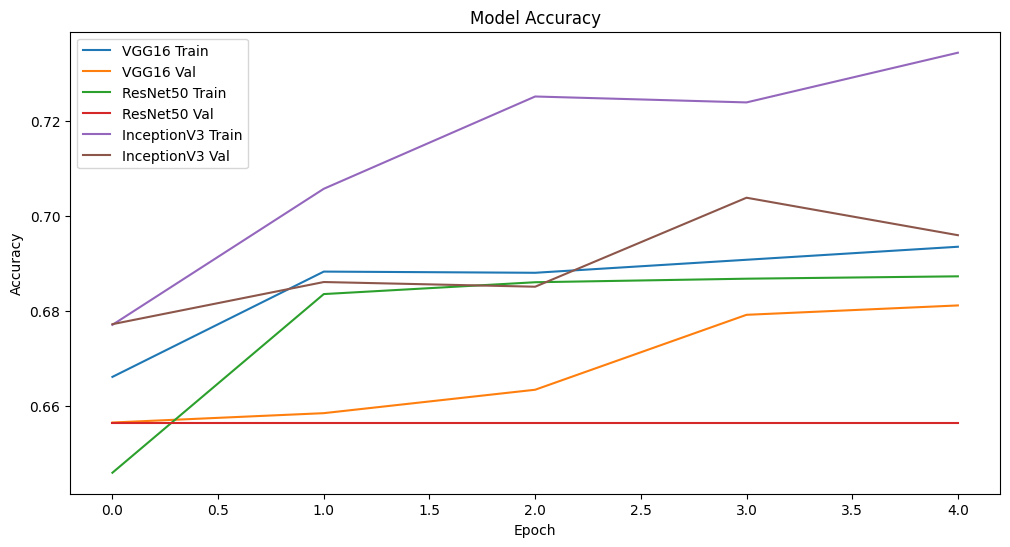

In [ ]:
# Plot Training History (Accuracy)
plt.figure(figsize=(12, 6))
for model_name, history in histories.items():
    plt.plot(history.history['accuracy'], label=f'{model_name} Train')
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Val')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Print out final results


In [ ]:
# Print out final results
print("Final Results Summary:")
for model_name, metrics in results.items():
    print(f"\nModel: {model_name}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")

Final Results Summary:

Model: VGG16
Accuracy: 0.6811451315879822
Loss: 0.9744730591773987
Precision: 0.4782496979853673
Recall: 0.6238894373149062
F1 Score: 0.5303294299308992

Model: ResNet50
Accuracy: 0.6564659476280212
Loss: 1.1585967540740967
Precision: 0.4309475339831938
Recall: 0.6564659427443238
F1 Score: 0.5203216351906739

Model: InceptionV3
Accuracy: 0.6959525942802429
Loss: 0.8489340543746948
Precision: 0.5001234892491297
Recall: 0.6090819348469891
F1 Score: 0.5280732345295913
